In [314]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib inline
from ipywidgets import interactive
import ipywidgets as widgets
from ipywidgets import fixed
from numpy import linalg as LA
import pandas as pd
from tqdm import tqdm

### Part 1 ###

Load the data and define some learning functions.

In [2]:
data = pd.read_csv('berkeley_azi_alt.csv', delimiter = ' ')

In [3]:
data

,time,sun_a_azi,sun_a_alt,sun_b_azi,sun_b_alt,moon_azi,moon_alt
0,0,210.3047,48.3867,210.3047,48.3871,30.3047,-48.9794
1,1000,215.8795,46.5747,215.8578,46.5935,35.7530,-47.2948
2,2000,221.0699,44.5101,221.0315,44.5493,40.8457,-45.3705
3,3000,225.8873,42.2270,225.8364,42.2880,45.5901,-43.2371
4,4000,230.3553,39.7568,230.2954,39.8405,50.0050,-40.9230
...,...,...,...,...,...,...,...
315356,315356000,165.5126,55.9819,184.0000,52.1938,232.8500,12.1685
315357,315357000,172.9150,56.6068,190.7356,51.7736,235.7127,9.5961
315358,315358000,180.4756,56.8033,197.2919,50.9764,238.4674,6.9366
315359,315359000,188.0278,56.5638,203.5788,49.8250,241.1250,4.1995


In [4]:
n = len(data)
print(n)
t_arr = np.zeros(n,)
azi_arr_a = np.zeros(n,)
alt_arr_a = np.zeros(n,)
azi_arr_b = np.zeros(n,)
alt_arr_b = np.zeros(n,)
azi_arr_m = np.zeros(n,)
alt_arr_m = np.zeros(n,)

315361


In [5]:
t = np.array(data['time'])

azi_arr_a = np.array(data['sun_a_azi'])
azi_arr_b = np.array(data['sun_b_azi'])
azi_arr_m = np.array(data['moon_azi'])

In [6]:
t_arr = np.copy(t)
t_arr = t_arr/1e7

In [7]:
period_earth_self = 24*60*60 / 1e7
period_earth_sun  = 365*24*60*60 / 1e7
w1 = 2*np.pi / period_earth_self
w2 = 2*np.pi / period_earth_sun
print(w1, w2)

727.220521664304 1.9923849908611069


In [354]:
def features_azi(X, w, N=50):
    n   = len(X)
    
    phi = np.zeros((n, 2*N+1))
    
    phi[:, 0] = 1
    for i in range(N):
        phi[:, 2*i+1] = np.cos((i+1)*w * X)
        phi[:, 2*i+2] = np.sin((i+1)*w * X)
    
    return phi

In [355]:
def calculate_w(X, y, lambda_):
    w = np.zeros((X.shape[1]))
    X_ = X[:, 1:]
    w_ = np.linalg.inv(X_.T@X_ + lambda_*np.eye(X_.shape[1]))@X_.T@y
    w[0] = 180
    w[1:] = w_
    return w

def predict(X, w):
    y_pred = X@w
    return y_pred

### Part 2 ###

In this part we study azimuth of Sun A.

Text(0.5, 0, 'Time(s) divided by 1e7')

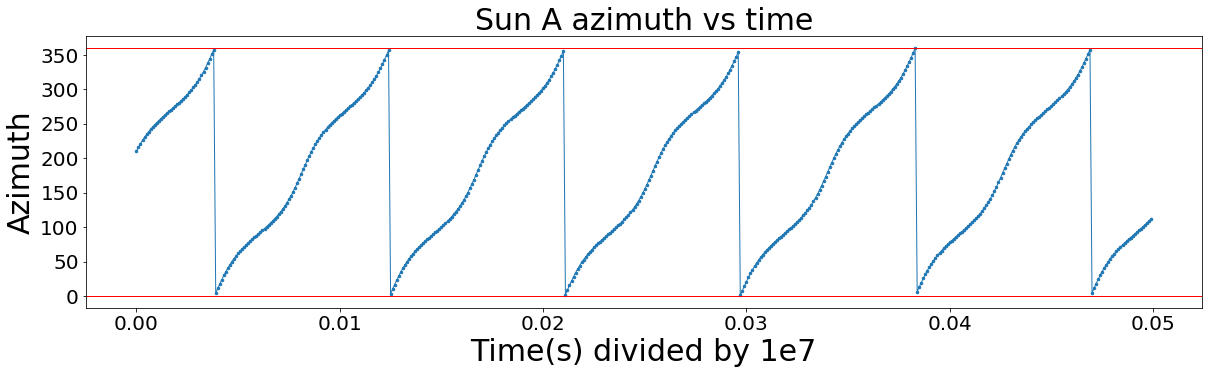

In [309]:
plt.figure(figsize=(20, 5))
plt.plot(t_arr[:500], azi_arr_a[:500], '.-', linewidth=1, markersize=5)
plt.axhline(y=0, c='r', linewidth=1)
plt.axhline(y=360, c='r', linewidth=1)
plt.title('Sun A azimuth vs time',fontsize = 30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Azimuth',fontsize = 30)
plt.xlabel('Time(s) divided by 1e7',fontsize = 30)

In [296]:
X_train_azi_a, X_test_azi_a, y_train_azi_a, y_test_azi_a = train_test_split(t_arr[:], azi_arr_a[:], test_size=0.4, random_state=42)

We first use k-fold cross validation to learn the best $\omega$ hyperparameter. Here we set $k = 5$ and the hyperparameter range is chosen based on the results from matlab fitting.

In [445]:
w_list = np.linspace(727.2, 727.23, 100)
loss_train_azi_a_list = []
loss_valid_azi_a_list = []
for i in tqdm(range(len(w_list))):
    N_features = 20
    w = w_list[i]
    k_fold = 5
    kf = KFold(n_splits=k_fold)
    loss_train = []
    loss_valid = []
    for train_index, valid_index in kf.split(X_train_azi_a):
        #print("TRAIN:", train_index, "VALID:", valid_index)
        X_train, X_valid = X_train_azi_a[train_index], X_train_azi_a[valid_index]
        y_train, y_valid = y_train_azi_a[train_index], y_train_azi_a[valid_index]
        
        phi_train = features_azi(X_train, w, N=N_features)
        phi_valid = features_azi(X_valid, w, N=N_features)

        w_hat = calculate_w(phi_train, y_train, 0)
        y_train_pred = predict(phi_train, w_hat)
        y_valid_pred = predict(phi_valid, w_hat)
        
        loss_train.append(np.mean((y_train_pred - y_train) **2))
        loss_valid.append(np.mean((y_valid_pred - y_valid) **2))
    loss_train = np.array(loss_train)
    loss_valid = np.array(loss_valid)
    
    loss_train_azi_a_list.append(np.mean(loss_train))
    loss_valid_azi_a_list.append(np.mean(loss_valid))

100%|██████████████████████████████████████████████████| 100/100 [02:16<00:00,  1.37s/it]


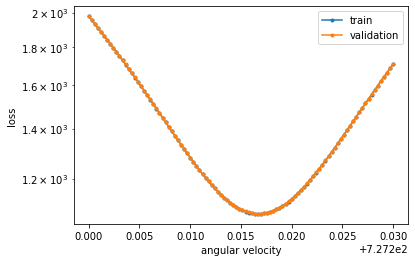

In [446]:
plt.semilogy(w_list, loss_train_azi_a_list, '.-', label='train')
plt.semilogy(w_list, loss_valid_azi_a_list, '.-', label='validation')
plt.xlabel('angular velocity')
plt.ylabel('loss')
plt.legend()

In [448]:
for i in range(len(w_list)):
    if loss_valid_azi_a_list[i] == min(loss_valid_azi_a_list):
        w_star = w_list[i]
print(w_star)

727.2166666666667


We second use k-fold cross validation to learn the best number of Fourier features $N$ hyperparameter. Here we set $k = 5$.

In [449]:
N_features_list = range(10, 50)
loss_train_azi_a_list = []
loss_valid_azi_a_list = []
for i in tqdm(range(len(N_features_list))):
    N_features = N_features_list[i]
    k_fold = 5
    kf = KFold(n_splits=k_fold)
    loss_train = []
    loss_valid = []
    for train_index, valid_index in kf.split(X_train_azi_a):
        #print("TRAIN:", train_index, "VALID:", valid_index)
        X_train, X_valid = X_train_azi_a[train_index], X_train_azi_a[valid_index]
        y_train, y_valid = y_train_azi_a[train_index], y_train_azi_a[valid_index]
        
        phi_train = features_azi(X_train, w=w_star, N=N_features)
        phi_valid = features_azi(X_valid, w=w_star, N=N_features)

        w_hat = calculate_w(phi_train, y_train, 0)
        y_train_pred = predict(phi_train, w_hat)
        y_valid_pred = predict(phi_valid, w_hat)
        
        loss_train.append(np.mean((y_train_pred - y_train) **2))
        loss_valid.append(np.mean((y_valid_pred - y_valid) **2))
    loss_train = np.array(loss_train)
    loss_valid = np.array(loss_valid)
    
    loss_train_azi_a_list.append(np.mean(loss_train))
    loss_valid_azi_a_list.append(np.mean(loss_valid))

100%|████████████████████████████████████████████████████| 40/40 [01:29<00:00,  2.25s/it]


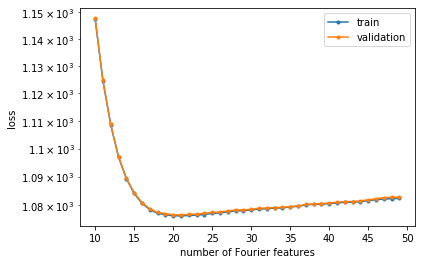

In [450]:
plt.semilogy(N_features_list, loss_train_azi_a_list, '.-', label='train')
plt.semilogy(N_features_list, loss_valid_azi_a_list, '.-', label='validation')
plt.xlabel('number of Fourier features')
plt.ylabel('loss')
plt.legend()

In [451]:
for i in range(len(N_features_list)):
    if loss_valid_azi_a_list[i] == min(loss_valid_azi_a_list):
        N_features = N_features_list[i]
print(N_features)

20


In [458]:
phi_train_azi_a = features_azi(X_train_azi_a, w=w_star, N=N_features)
phi_test_azi_a  = features_azi(X_test_azi_a, w=w_star, N=N_features)

w_hat = calculate_w(phi_train_azi_a, y_train_azi_a, 0)
y_train_pred_azi_a = predict(phi_train_azi_a, w_hat)
y_test_pred_azi_a = predict(phi_test_azi_a, w_hat)
    
loss_train_azi_a = np.mean((y_train_pred_azi_a - y_train_azi_a) **2)
loss_test_azi_a = np.mean((y_test_pred_azi_a - y_test_azi_a) **2)
print(loss_train_azi_a, loss_test_azi_a)

1074.5887152380747 1065.682161605645


In [459]:
phi_azi_a = features_azi(t_arr, w=w_star, N=N_features)
azi_arr_a_pred = predict(phi_azi_a, w_hat)

Text(0.5, 0, 'Time(s) divided by 1e7')

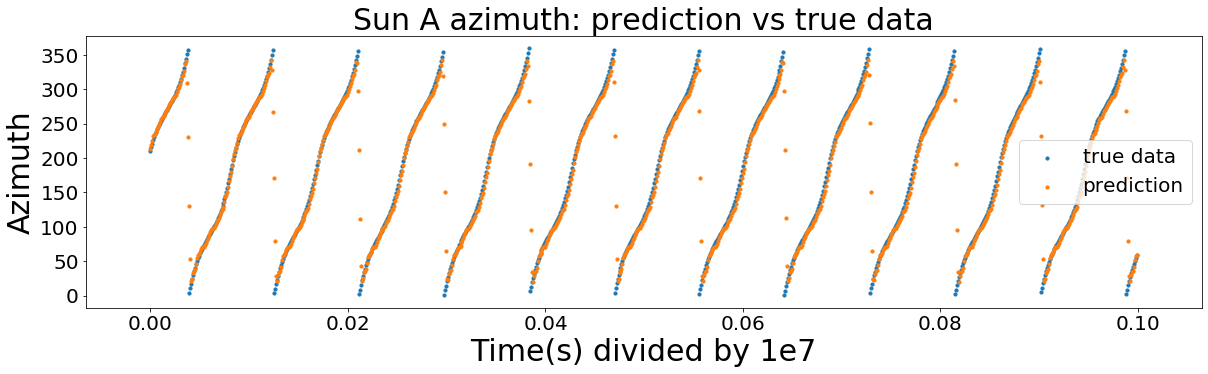

In [460]:
plt.figure(figsize=(20, 5))
plt.scatter(t_arr[:1000], azi_arr_a[:1000], s=10, label='true data')
plt.scatter(t_arr[:1000], azi_arr_a_pred[:1000], s=10, label='prediction')
plt.title('Sun A azimuth: prediction vs true data', fontsize = 30)
plt.legend(fontsize = 20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Azimuth',fontsize = 30)
plt.xlabel('Time(s) divided by 1e7',fontsize = 30)

### Part 3 ###

In this part we study azimuth of Sun B.

Text(0.5, 0, 'Time(s) divided by 1e7')

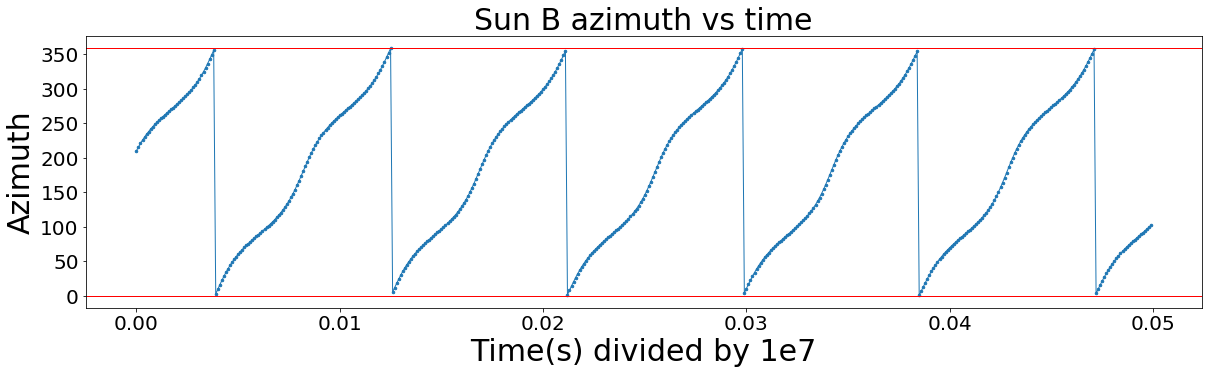

In [356]:
plt.figure(figsize=(20, 5))
plt.plot(t_arr[:500], azi_arr_b[:500], '.-', linewidth=1, markersize=5)
plt.axhline(y=0, c='r', linewidth=1)
plt.axhline(y=360, c='r', linewidth=1)
plt.title('Sun B azimuth vs time',fontsize = 30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Azimuth',fontsize = 30)
plt.xlabel('Time(s) divided by 1e7',fontsize = 30)

In [357]:
X_train_azi_b, X_test_azi_b, y_train_azi_b, y_test_azi_b = train_test_split(t_arr[:], azi_arr_b[:], test_size=0.4, random_state=42)

We first use k-fold cross validation to learn the best $\omega$ hyperparameter. Here we set $k = 5$ and the hyperparameter range is chosen based on the results from matlab fitting.

In [464]:
w_list = np.linspace(727.2, 727.23, 100)
loss_train_azi_b_list = []
loss_valid_azi_b_list = []
for i in tqdm(range(len(w_list))):
    N_features = 20
    w = w_list[i]
    k_fold = 5
    kf = KFold(n_splits=k_fold)
    loss_train = []
    loss_valid = []
    for train_index, valid_index in kf.split(X_train_azi_b):
        #print("TRAIN:", train_index, "VALID:", valid_index)
        X_train, X_valid = X_train_azi_b[train_index], X_train_azi_b[valid_index]
        y_train, y_valid = y_train_azi_b[train_index], y_train_azi_b[valid_index]
        
        phi_train = features_azi(X_train, w, N=N_features)
        phi_valid = features_azi(X_valid, w, N=N_features)

        w_hat = calculate_w(phi_train, y_train, 0)
        y_train_pred = predict(phi_train, w_hat)
        y_valid_pred = predict(phi_valid, w_hat)
        
        loss_train.append(np.mean((y_train_pred - y_train) **2))
        loss_valid.append(np.mean((y_valid_pred - y_valid) **2))
    loss_train = np.array(loss_train)
    loss_valid = np.array(loss_valid)
    
    loss_train_azi_b_list.append(np.mean(loss_train))
    loss_valid_azi_b_list.append(np.mean(loss_valid))

100%|██████████████████████████████████████████████████| 100/100 [02:21<00:00,  1.41s/it]


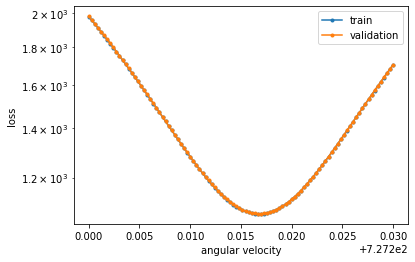

In [465]:
plt.semilogy(w_list, loss_train_azi_b_list, '.-', label='train')
plt.semilogy(w_list, loss_valid_azi_b_list, '.-', label='validation')
plt.xlabel('angular velocity')
plt.ylabel('loss')
plt.legend()

In [468]:
for i in range(len(w_list)):
    if loss_valid_azi_b_list[i] == min(loss_valid_azi_b_list):
        w_star = w_list[i]
print(w_star)

727.2166666666667


We second use k-fold cross validation to learn the best number of Fourier features $N$ hyperparameter. Here we set $k = 5$.

In [469]:
N_features_list = range(10, 50)
loss_train_azi_b_list = []
loss_valid_azi_b_list = []
for i in tqdm(range(len(N_features_list))):
    N_features = N_features_list[i]
    k_fold = 5
    kf = KFold(n_splits=k_fold)
    loss_train = []
    loss_valid = []
    for train_index, valid_index in kf.split(X_train_azi_b):
        #print("TRAIN:", train_index, "VALID:", valid_index)
        X_train, X_valid = X_train_azi_b[train_index], X_train_azi_b[valid_index]
        y_train, y_valid = y_train_azi_b[train_index], y_train_azi_b[valid_index]
        
        phi_train = features_azi(X_train, w=w_star, N=N_features)
        phi_valid = features_azi(X_valid, w=w_star, N=N_features)

        w_hat = calculate_w(phi_train, y_train, 0)
        y_train_pred = predict(phi_train, w_hat)
        y_valid_pred = predict(phi_valid, w_hat)
        
        loss_train.append(np.mean((y_train_pred - y_train) **2))
        loss_valid.append(np.mean((y_valid_pred - y_valid) **2))
    loss_train = np.array(loss_train)
    loss_valid = np.array(loss_valid)
    
    loss_train_azi_b_list.append(np.mean(loss_train))
    loss_valid_azi_b_list.append(np.mean(loss_valid))

100%|████████████████████████████████████████████████████| 40/40 [01:23<00:00,  2.10s/it]


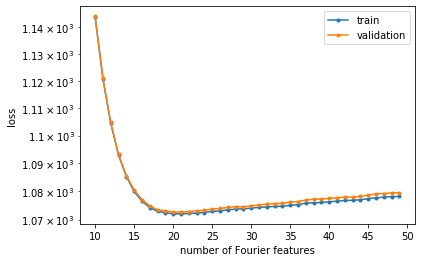

In [470]:
plt.semilogy(N_features_list, loss_train_azi_b_list, '.-', label='train')
plt.semilogy(N_features_list, loss_valid_azi_b_list, '.-', label='validation')
plt.xlabel('number of Fourier features')
plt.ylabel('loss')
plt.legend()

In [471]:
for i in range(len(N_features_list)):
    if loss_valid_azi_b_list[i] == min(loss_valid_azi_b_list):
        N_features = N_features_list[i]
print(N_features)

21


In [472]:
phi_train_azi_b = features_azi(X_train_azi_b, w=w_star, N=N_features)
phi_test_azi_b  = features_azi(X_test_azi_b, w=w_star, N=N_features)

w_hat = calculate_w(phi_train_azi_b, y_train_azi_b, 0)
y_train_pred_azi_b = predict(phi_train_azi_b, w_hat)
y_test_pred_azi_b = predict(phi_test_azi_b, w_hat)
    
loss_train_azi_b = np.mean((y_train_pred_azi_b - y_train_azi_b) **2)
loss_test_azi_b = np.mean((y_test_pred_azi_b - y_test_azi_b) **2)
print(loss_train_azi_b, loss_test_azi_b)

1070.3141034542878 1064.3395435718296


In [473]:
phi_azi_b = features_azi(t_arr, w=w_star, N=N_features)
azi_arr_b_pred = predict(phi_azi_b, w_hat)

Text(0.5, 0, 'Time(s) divided by 1e7')

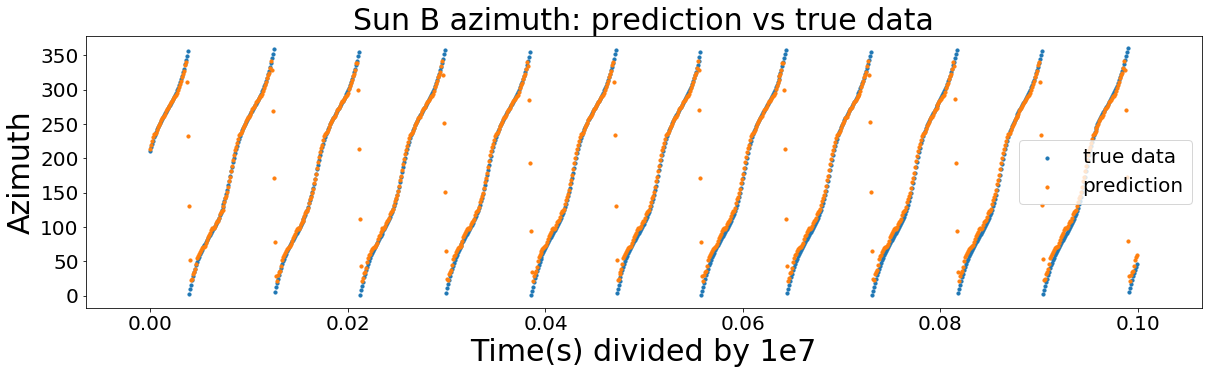

In [474]:
plt.figure(figsize=(20, 5))
plt.scatter(t_arr[:1000], azi_arr_b[:1000], s=10, label='true data')
plt.scatter(t_arr[:1000], azi_arr_b_pred[:1000], s=10, label='prediction')
plt.title('Sun B azimuth: prediction vs true data', fontsize = 30)
plt.legend(fontsize = 20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Azimuth',fontsize = 30)
plt.xlabel('Time(s) divided by 1e7',fontsize = 30)

### Part 4 ###

In this part we study azimuth of Moon.

Text(0.5, 0, 'Time(s) divided by 1e7')

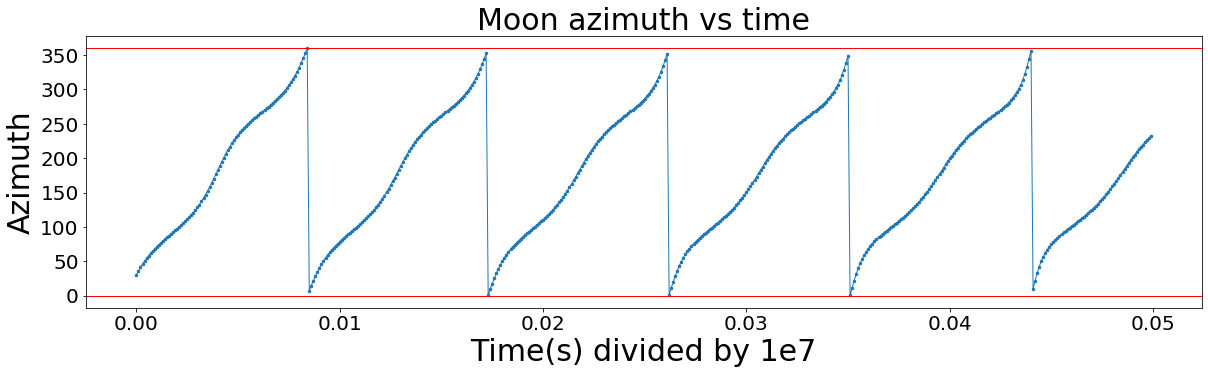

In [379]:
plt.figure(figsize=(20, 5))
plt.plot(t_arr[:500], azi_arr_m[:500], '.-', linewidth=1, markersize=5)
plt.axhline(y=0, c='r', linewidth=1)
plt.axhline(y=360, c='r', linewidth=1)
plt.title('Moon azimuth vs time',fontsize = 30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Azimuth',fontsize = 30)
plt.xlabel('Time(s) divided by 1e7',fontsize = 30)

In [380]:
X_train_azi_m, X_test_azi_m, y_train_azi_m, y_test_azi_m = train_test_split(t_arr[:], azi_arr_m[:], test_size=0.4, random_state=42)

We first use k-fold cross validation to learn the best $\omega$ hyperparameter. Here we set $k = 5$ and the hyperparameter range is chosen based on the results from matlab fitting.

In [475]:
w_list = np.linspace(702.22, 702.27, 100)
loss_train_azi_m_list = []
loss_valid_azi_m_list = []
for i in tqdm(range(len(w_list))):
    N_features = 20
    w = w_list[i]
    k_fold = 5
    kf = KFold(n_splits=k_fold)
    loss_train = []
    loss_valid = []
    for train_index, valid_index in kf.split(X_train_azi_m):
        #print("TRAIN:", train_index, "VALID:", valid_index)
        X_train, X_valid = X_train_azi_m[train_index], X_train_azi_m[valid_index]
        y_train, y_valid = y_train_azi_m[train_index], y_train_azi_m[valid_index]
        
        phi_train = features_azi(X_train, w, N=N_features)
        phi_valid = features_azi(X_valid, w, N=N_features)

        w_hat = calculate_w(phi_train, y_train, 0)
        y_train_pred = predict(phi_train, w_hat)
        y_valid_pred = predict(phi_valid, w_hat)
        
        loss_train.append(np.mean((y_train_pred - y_train) **2))
        loss_valid.append(np.mean((y_valid_pred - y_valid) **2))
    loss_train = np.array(loss_train)
    loss_valid = np.array(loss_valid)
    
    loss_train_azi_m_list.append(np.mean(loss_train))
    loss_valid_azi_m_list.append(np.mean(loss_valid))

100%|██████████████████████████████████████████████████| 100/100 [02:18<00:00,  1.39s/it]


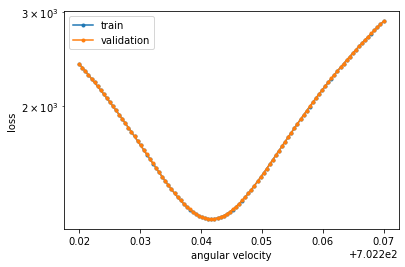

In [476]:
plt.semilogy(w_list, loss_train_azi_m_list, '.-', label='train')
plt.semilogy(w_list, loss_valid_azi_m_list, '.-', label='validation')
plt.xlabel('angular velocity')
plt.ylabel('loss')
plt.legend()

In [477]:
for i in range(len(w_list)):
    if loss_valid_azi_m_list[i] == min(loss_valid_azi_m_list):
        w_star = w_list[i]
print(w_star)

702.2417171717171


We second use k-fold cross validation to learn the best number of Fourier features $N$ hyperparameter. Here we set $k = 5$.

In [478]:
N_features_list = range(10, 50)
loss_train_azi_m_list = []
loss_valid_azi_m_list = []
for i in tqdm(range(len(N_features_list))):
    N_features = N_features_list[i]
    k_fold = 5
    kf = KFold(n_splits=k_fold)
    loss_train = []
    loss_valid = []
    for train_index, valid_index in kf.split(X_train_azi_m):
        #print("TRAIN:", train_index, "VALID:", valid_index)
        X_train, X_valid = X_train_azi_m[train_index], X_train_azi_m[valid_index]
        y_train, y_valid = y_train_azi_m[train_index], y_train_azi_m[valid_index]
        
        phi_train = features_azi(X_train, w=w_star, N=N_features)
        phi_valid = features_azi(X_valid, w=w_star, N=N_features)

        w_hat = calculate_w(phi_train, y_train, 0)
        y_train_pred = predict(phi_train, w_hat)
        y_valid_pred = predict(phi_valid, w_hat)
        
        loss_train.append(np.mean((y_train_pred - y_train) **2))
        loss_valid.append(np.mean((y_valid_pred - y_valid) **2))
    loss_train = np.array(loss_train)
    loss_valid = np.array(loss_valid)
    
    loss_train_azi_m_list.append(np.mean(loss_train))
    loss_valid_azi_m_list.append(np.mean(loss_valid))

100%|████████████████████████████████████████████████████| 40/40 [01:33<00:00,  2.34s/it]


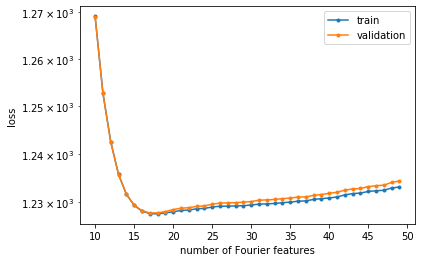

In [480]:
plt.semilogy(N_features_list, loss_train_azi_m_list, '.-', label='train')
plt.semilogy(N_features_list, loss_valid_azi_m_list, '.-', label='validation')
plt.xlabel('number of Fourier features')
plt.ylabel('loss')
plt.legend()

In [481]:
for i in range(len(N_features_list)):
    if loss_valid_azi_m_list[i] == min(loss_valid_azi_m_list):
        N_features = N_features_list[i]
print(N_features)

17


In [482]:
phi_train_azi_m = features_azi(X_train_azi_m, w=w_star, N=N_features)
phi_test_azi_m  = features_azi(X_test_azi_m, w=w_star, N=N_features)

w_hat = calculate_w(phi_train_azi_m, y_train_azi_m, 0)
y_train_pred_azi_m = predict(phi_train_azi_m, w_hat)
y_test_pred_azi_m = predict(phi_test_azi_m, w_hat)
    
loss_train_azi_m = np.mean((y_train_pred_azi_m - y_train_azi_m) **2)
loss_test_azi_m = np.mean((y_test_pred_azi_m - y_test_azi_m) **2)
print(loss_train_azi_m, loss_test_azi_m)

1226.162970228049 1208.3566740091096


In [483]:
phi_azi_m = features_azi(t_arr, w=w_star, N=N_features)
azi_arr_m_pred = predict(phi_azi_m, w_hat)

Text(0.5, 0, 'Time(s) divided by 1e7')

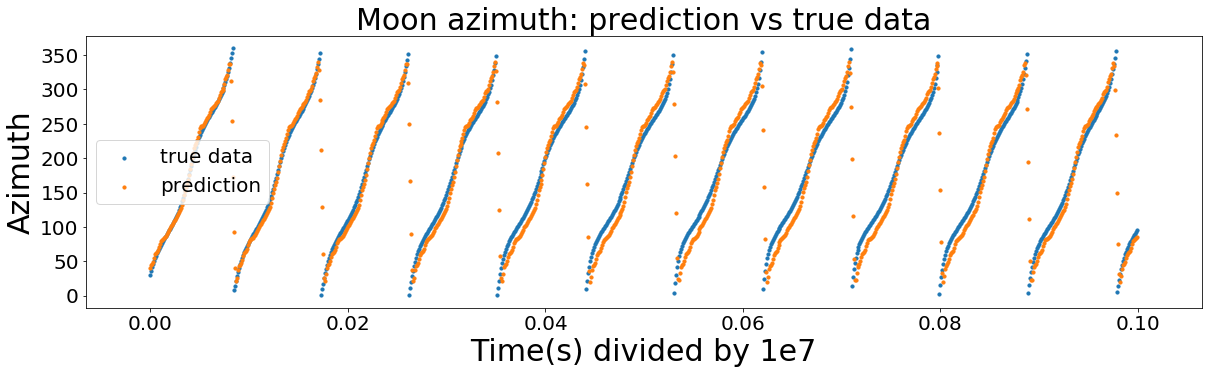

In [484]:
plt.figure(figsize=(20, 5))
plt.scatter(t_arr[:1000], azi_arr_m[:1000], s=10, label='true data')
plt.scatter(t_arr[:1000], azi_arr_m_pred[:1000], s=10, label='prediction')
plt.title('Moon azimuth: prediction vs true data', fontsize = 30)
plt.legend(fontsize = 20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Azimuth',fontsize = 30)
plt.xlabel('Time(s) divided by 1e7',fontsize = 30)